In [1]:
import pandas as pd
import numpy as np
from numpy.random import SeedSequence
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.signal import detrend
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator

In [2]:
df = pd.read_csv("Data/Cleaned_df_386.csv").drop(columns = ["Unnamed: 0"])
df['Date'] = pd.to_datetime(df['Date'])
Rosters = df["Roster_ID"].unique()
df_1 = df[df["Roster_ID"]==Rosters[1]]
dates = df_1["Date"]
T = len(df_1)

In [3]:
df

,Date,State,Roster_ID,Population_Interpolated,Missing_Indicator,Admissions_Interpolated,Releases_Interpolated,Admin2,Province_State,Population,Cases,Deaths,State Name
0,2020-03-01,AL,AL-Autauga,169.914286,0.285714,3.971429,4.114286,Autauga,AL,55869,0.000000,0.000000,Alabama
1,2020-03-08,AL,AL-Autauga,171.514286,0.285714,4.171429,4.742857,Autauga,AL,55869,0.000000,0.000000,Alabama
2,2020-03-15,AL,AL-Autauga,175.142857,0.000000,6.000000,4.000000,Autauga,AL,55869,0.000000,0.000000,Alabama
3,2020-03-22,AL,AL-Autauga,164.428571,0.000000,1.857143,5.142857,Autauga,AL,55869,0.000000,0.000000,Alabama
4,2020-03-29,AL,AL-Autauga,155.714286,0.000000,2.857143,3.428571,Autauga,AL,55869,0.452381,0.000000,Alabama
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17635,2022-01-30,WY,WY-Park,45.428571,0.000000,0.857143,1.285714,Park,WY,29194,0.004886,0.003456,Wyoming
17636,2022-02-06,WY,WY-Park,42.428571,0.000000,0.714286,1.000000,Park,WY,29194,0.003713,0.003375,Wyoming
17637,2022-02-13,WY,WY-Park,42.142857,0.000000,1.285714,1.000000,Park,WY,29194,0.001959,0.001099,Wyoming
17638,2022-02-20,WY,WY-Park,40.571429,0.000000,1.142857,1.428571,Park,WY,29194,0.001119,0.001091,Wyoming


In [4]:
States, counts = np.unique(df["State Name"].values, return_counts = True)
counts = counts/T 

In [5]:
plt.rcParams.update({
    'font.size' : 15,
    "lines.linewidth": 2,
    "font.family":"arial",
    #"font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "mathtext.default": "rm",
    "mathtext.rm"  : "arial",
        })

<Figure size 500x1000 with 0 Axes>

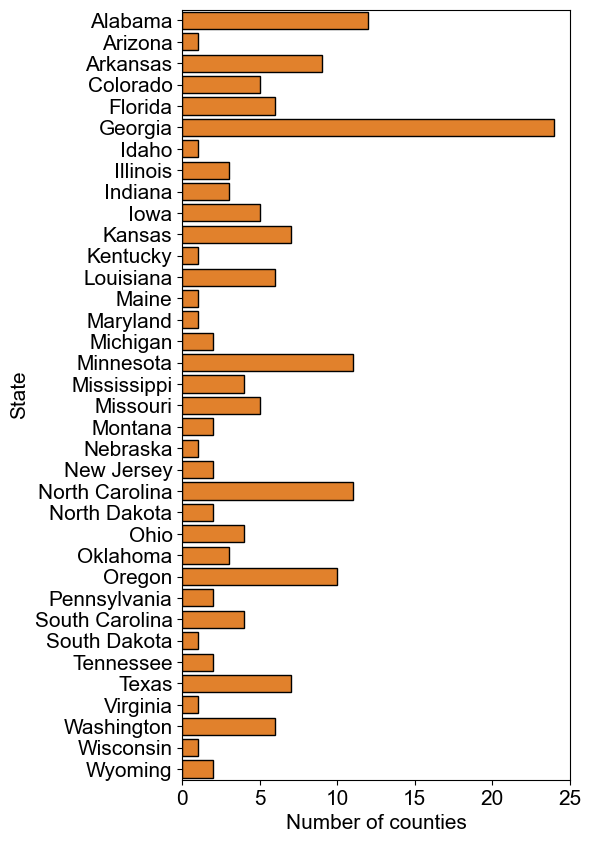

In [6]:
plt.figure(figsize=(5, 10))  # Adjust figure size for better readability
fig,(ax)  = plt.subplots(1, 1, sharey='row',figsize=(5,10))
sns.barplot(y=States, x=counts, edgecolor="black", color="C1", ax = ax)  # Swap x and y
ax.set_ylabel("State")
ax.set_xlabel("Number of counties")
ax.set_xlim([0,25])
# ax.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.savefig("Results/States.pdf", bbox_inches="tight")
plt.show()

In [7]:
All_Jails_pop = np.zeros([len(Rosters),T])
All_Cases = np.zeros([len(Rosters),T])

for i, Roster in enumerate(Rosters):
    l_df = df[df["Roster_ID"]==Roster]
    J = l_df["Population_Interpolated"].values
    C = l_df["Cases"].values
    All_Jails_pop[i] = J
    All_Cases[i] = C

In [8]:
def dt(data):
    deterended_data = np.zeros(data.shape)
    for i in range(data.shape[0]):
        deterended_data[i] =  detrend(data[i], type='constant')
    return deterended_data

In [9]:
All_Jails_pop = dt(All_Jails_pop)
All_Cases = dt(All_Cases)
# Compute means
mean_C = np.mean(All_Cases, axis=0)
mean_J = np.mean(All_Jails_pop, axis=0)

# Compute 95% confidence intervals
ste_C = np.std(All_Cases, axis=0) / np.sqrt(All_Cases.shape[0])
ste_J = np.std(All_Jails_pop, axis=0) / np.sqrt(All_Jails_pop.shape[0])

CI_C_upper = mean_C + 1.96 * ste_C
CI_C_lower = mean_C - 1.96 * ste_C
CI_J_upper = mean_J + 1.96 * ste_J
CI_J_lower = mean_J - 1.96 * ste_J


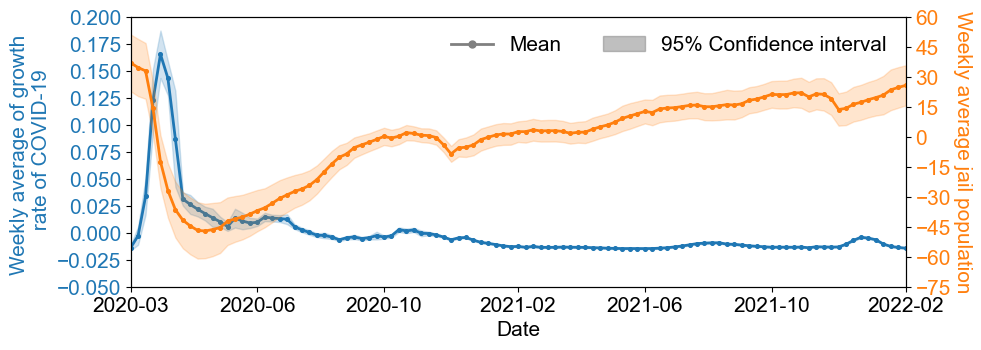

In [10]:
fig, ax1 = plt.subplots(figsize=(10, 3.5))

# Plot C on primary axis
ax1.plot(dates, mean_C, color='C0')
ax1.scatter(dates, mean_C, color='C0', s=7)
ax1.fill_between(dates, CI_C_lower, CI_C_upper, color='C0', alpha=0.2)
ax1.set_xlabel("Date")
ax1.set_ylabel("Weekly average of growth \n rate of COVID-19", color='C0', alpha=1)
ax1.tick_params(axis='y', labelcolor='C0')

# --- Match Y-axis formatting to second plot ---
ax1.ticklabel_format(axis='y', style='plain')  # Disable scientific notation
ax1.yaxis.get_offset_text().set_visible(False)  # Hide offset text
ax1.yaxis.set_major_locator(MaxNLocator(min_n_ticks=4))  # Ensure at least 4 ticks
yticks1 = ax1.get_yticks()
ax1.set_ylim(yticks1[0], yticks1[-1])  # Fix y-axis range

# Set custom x-axis ticks
indices = np.linspace(0, len(dates) - 1, 7, dtype=int)
sampled_dates = [np.array(dates)[i] for i in indices]
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.set_xticks(pd.to_datetime(sampled_dates))
ax1.set_xlim(pd.to_datetime(sampled_dates)[0], pd.to_datetime(sampled_dates)[-1])

# Plot J on secondary axis
ax2 = ax1.twinx()
ax2.plot(dates, mean_J, color='C1')
ax2.scatter(dates, mean_J, color='C1', s=7)
ax2.fill_between(dates, CI_J_lower, CI_J_upper, color='C1', alpha=0.2)
ax2.set_ylabel("Weekly average jail population", color='C1', alpha=1, rotation=270, labelpad=15)
ax2.tick_params(axis='y', labelcolor='C1')

# --- Match Y-axis formatting to second plot ---
ax2.ticklabel_format(axis='y', style='plain')
ax2.yaxis.get_offset_text().set_visible(False)
ax2.yaxis.set_major_locator(MaxNLocator(min_n_ticks=4))
yticks2 = ax2.get_yticks()
ax2.set_ylim(yticks2[0], yticks2[-1])

# Legend
line_with_dot_handle = mlines.Line2D([], [], color='gray', marker='o', linestyle='-', markersize=5, label="Mean")
shaded_handle = mpatches.Patch(color='gray', alpha=0.5, label="95% Confidence interval")
ax1.legend(handles=[line_with_dot_handle, shaded_handle], frameon=False, ncol=2)

plt.savefig("Results/TS.pdf", bbox_inches="tight")
plt.show()